Import oraz instalcja potrzebnych bibliotek

In [ ]:
!pip3 install opencv-python keras tensorflow kagglehub

In [ ]:
import kagglehub

# import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

import cv2 as cv
from google.colab.patches import cv2_imshow

# from sklearn.linear_model import LinearRegression
# from sklearn.datasets import fetch_openml
# from sklearn.model_selection import train_test_split
# from sklearn.datasets import load_files

import os

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.preprocessing import image

import PIL

from tensorflow import keras

# from keras.applications import ImageDataGenerator, img_to_array, load_img
# from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

Pobranie zestawu danych

In [ ]:
path = kagglehub.dataset_download("sadmansakibmahi/plant-disease-expert")

100%|██████████| 9.33G/9.33G [01:58<00:00, 84.5MB/s]

Extracting files...


In [ ]:
import pathlib

print(path)

data_path = f'{path}/Image Data base/Image Data base/'

data_dir = pathlib.Path(data_path)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

/root/.cache/kagglehub/datasets/sadmansakibmahi/plant-disease-expert/versions/17
199665


Wczytanie oraz podzielenie na zbiory testowy/walidacyjny oraz klasy

In [ ]:
# Define the path to the image folders
data_path = f'{path}/Image Data base/Image Data base/'

batch_size = 8
img_height = 224
img_width = 224

train_ds = keras.utils.image_dataset_from_directory(
    data_path,
    # labels='inferred',
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds  = keras.utils.image_dataset_from_directory(
    data_path,
    # labels='inferred',
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 199665 files belonging to 58 classes.
Using 159732 files for training.
Found 199665 files belonging to 58 classes.
Using 39933 files for validation.


Sprawdzenie jak wyglądają poszczególne próbki

['Apple Apple scab', 'Apple Black rot', 'Apple Cedar apple rust', 'Apple healthy', 'Bacterial leaf blight in rice leaf', 'Blight in corn Leaf', 'Blueberry healthy', 'Brown spot in rice leaf', 'Cercospora leaf spot', 'Cherry (including sour) Powdery mildew', 'Cherry (including_sour) healthy', 'Common Rust in corn Leaf', 'Corn (maize) healthy', 'Garlic', 'Grape Black rot', 'Grape Esca Black Measles', 'Grape Leaf blight Isariopsis Leaf Spot', 'Grape healthy', 'Gray Leaf Spot in corn Leaf', 'Leaf smut in rice leaf', 'Nitrogen deficiency in plant', 'Orange Haunglongbing Citrus greening', 'Peach healthy', 'Pepper bell Bacterial spot', 'Pepper bell healthy', 'Potato Early blight', 'Potato Late blight', 'Potato healthy', 'Raspberry healthy', 'Sogatella rice', 'Soybean healthy', 'Strawberry Leaf scorch', 'Strawberry healthy', 'Tomato Bacterial spot', 'Tomato Early blight', 'Tomato Late blight', 'Tomato Leaf Mold', 'Tomato Septoria leaf spot', 'Tomato Spider mites Two spotted spider mite', 'Toma

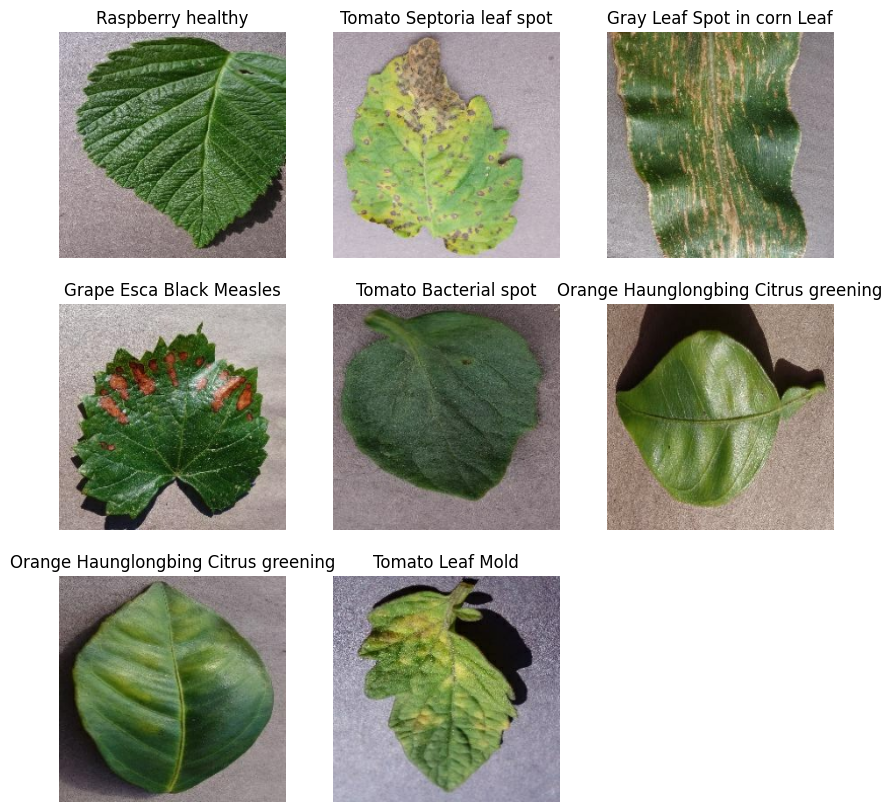

In [ ]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Przygotowanie modelu na podstawie ResNet50 i jego kompilacja

In [ ]:
num_classes = len(class_names)

resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    pooling='avg',
    classes=num_classes,
)
pretrained_model.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dense(num_classes, activation='softmax'))

model = resnet_model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
model.build()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 58)                  │          29,754 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,666,554 (94.10 MB)

 Trainable params: 1,078,842 (4.12 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Ustawienie warunków uczenia maszynowego oraz jego wykonanie

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Można też użyć 'val_accuracy'
    patience=2,          # Liczba epok bez poprawy
    restore_best_weights=True,
    verbose=1
)

In [ ]:
epochs = 4

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

model.save('saved_model/my_model_22_12_1.keras')

Epoch 1/4
19967/19967 ━━━━━━━━━━━━━━━━━━━━ 685s 34ms/step - accuracy: 0.9052 - loss: 0.3204 - val_accuracy: 0.9616 - val_loss: 0.1142
Epoch 2/4
19967/19967 ━━━━━━━━━━━━━━━━━━━━ 657s 33ms/step - accuracy: 0.9657 - loss: 0.1105 - val_accuracy: 0.9694 - val_loss: 0.1058
Epoch 3/4
19967/19967 ━━━━━━━━━━━━━━━━━━━━ 652s 33ms/step - accuracy: 0.9749 - loss: 0.0855 - val_accuracy: 0.9748 - val_loss: 0.1036
Epoch 4/4
19967/19967 ━━━━━━━━━━━━━━━━━━━━ 681s 33ms/step - accuracy: 0.9800 - loss: 0.0742 - val_accuracy: 0.9747 - val_loss: 0.1034


FileNotFoundError: [Errno 2] No such file or directory: 'saved_model/my_model_22_12_1.keras'

Zapisanie modelu do pliku

In [ ]:
model.save('saved_model/my_model_22_12_1.keras')

Sprawdzenie jak wyglądało trenowanie modelu

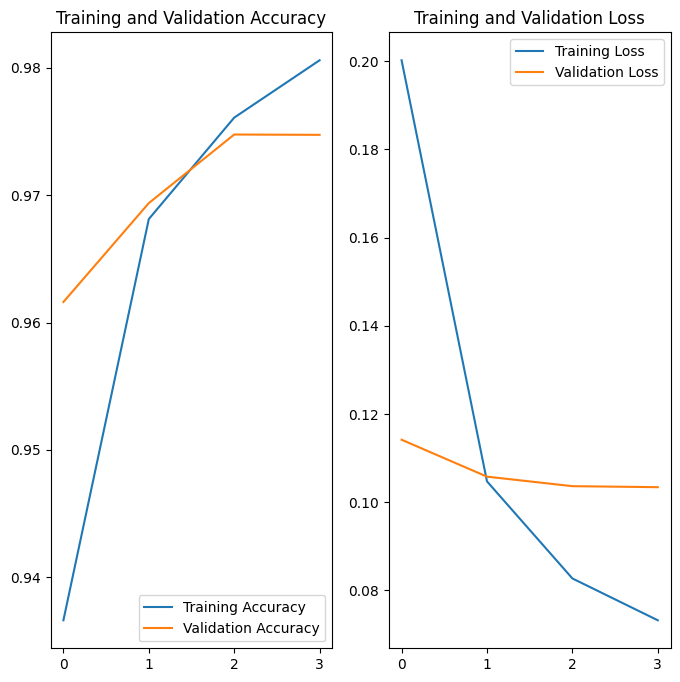

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()